In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, auc



In [2]:
tfd = tfp.distributions
tfpl = tfp.layers

# Load and preprocess IMDB dataset
(train_data, test_data), info = tfds.load('imdb_reviews', split=['train', 'test'], with_info=True, as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.KCH99D_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.KCH99D_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.KCH99D_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
# Tokenizer setup
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts([example.numpy().decode('utf-8') for example, _ in train_data])

def encode_pad(text, label):
    encoded = tokenizer.texts_to_sequences([text.numpy().decode('utf-8')])[0]
    padded = tf.keras.preprocessing.sequence.pad_sequences([encoded], maxlen=256, padding='post')[0]
    return padded, label

def encode_pad_map_fn(text, label):
    encoded_text, label = tf.py_function(encode_pad, inp=[text, label], Tout=(tf.int32, tf.int64))
    encoded_text.set_shape([256])
    label.set_shape([])
    return encoded_text, label

In [4]:
# Map and batch the data
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_data = train_data.map(encode_pad_map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = test_data.map(encode_pad_map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


In [5]:
# Bayesian Neural Network Model
class BNNModel(tf.keras.Model):
    def __init__(self):
        super(BNNModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=10000, output_dim=16)
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.dense_flipout_1 = tfpl.DenseFlipout(16, activation='relu')
        self.dense_flipout_2 = tfpl.DenseFlipout(1)

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.global_avg_pool(x)
        x = self.dense_flipout_1(x)
        return self.dense_flipout_2(x)


In [6]:
# Instantiate and compile the model
model = BNNModel()
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)


In [7]:
# Measure training time
start_time = time.time()
history = model.fit(train_data, epochs=10, validation_data=test_data)
end_time = time.time()


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


391/391 ━━━━━━━━━━━━━━━━━━━━ 67s 142ms/step - accuracy: 0.5024 - auc: 0.5093 - loss: 0.7056 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5000 - val_auc: 0.5084 - val_loss: 0.6987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.5021 - auc: 0.5266 - loss: 0.6977 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5000 - val_auc: 0.5250 - val_loss: 0.6959 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 62ms/step - accuracy: 0.5006 - auc: 0.5449 - loss: 0.6949 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5000 - val_auc: 0.5651 - val_loss: 0.6936 - val_precision: 1.0000 - val_recall: 8.0000e-05
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - accuracy: 0.4978 - auc: 0.5924 - loss: 0.6910 - precision: 0.1633 - recall: 2.0318e-05 - val_accuracy: 0.5004 - val_auc: 0.6023 - val_loss: 0.6903 - val_precision: 0.7368 - val_r

In [8]:
# Calculate Training Time & Scalability
training_time = end_time - start_time
print(f'Training Time: {training_time} seconds')


Training Time: 408.4151237010956 seconds


In [9]:
results = model.evaluate(test_data)
print(f'Test Loss: {results[0]}, Test Accuracy: {results[1]}, Precision: {results[2]}, Recall: {results[3]}, AUC: {results[4]}')


391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.5511 - auc: 0.7174 - loss: 0.6753 - precision: 0.8776 - recall: 0.1140
Test Loss: 0.6738111972808838, Test Accuracy: 0.5522400140762329, Precision: 0.885478138923645, Recall: 0.11999999731779099, AUC: 0.7218133807182312


In [10]:
# Predict and measure F1-Score, Precision, Recall
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred_logits = model.predict(test_data)
y_pred = tf.sigmoid(y_pred_logits).numpy().flatten()
y_pred_labels = (y_pred > 0.5).astype(int)

precision, recall, _ = precision_recall_curve(y_true, y_pred)
f1 = f1_score(y_true, y_pred_labels)
print(f'F1-Score: {f1}')

391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step
F1-Score: 0.6726831153060662


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


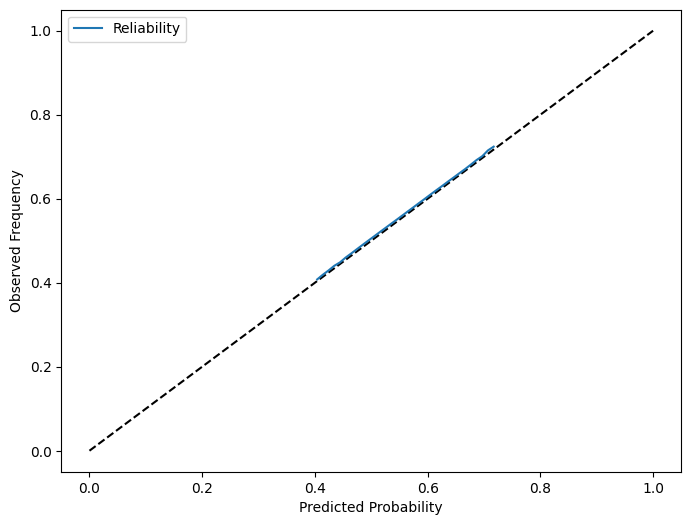

In [11]:
# Calibration and reliability diagram
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
probs = np.linspace(0, 1, 100)
reliability = [np.mean(y_pred[(y_pred > p) & (y_pred <= p+0.01)]) for p in probs]
plt.plot(probs, reliability, label="Reliability")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.legend()
plt.show()

In [12]:
# Predictive uncertainty - measuring variance in predictions
y_samples = [model.predict(test_data) for _ in range(10)]
y_var = np.var(y_samples, axis=0)
print(f'Predictive Variance: {np.mean(y_var)}')


391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step
Predictive Variance: 0.01162662822753191


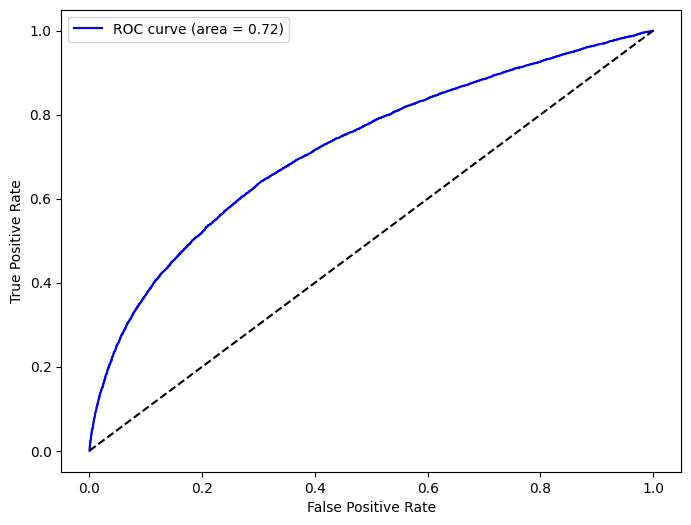

In [13]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

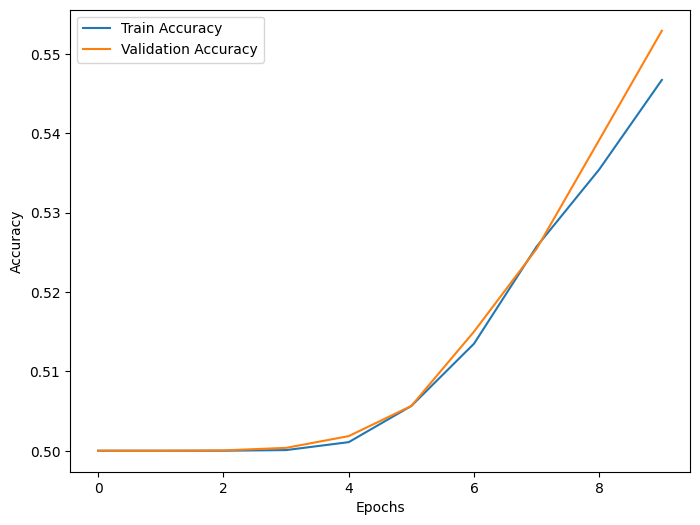

In [14]:
# Overfitting / Generalization Analysis
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [15]:
# Noise Sensitivity: Adding noise and measuring performance drop
noise = np.random.normal(0, 0.1, y_pred_logits.shape)
y_noisy_pred = tf.sigmoid(y_pred_logits + noise).numpy().flatten()
noisy_accuracy = np.mean((y_noisy_pred > 0.5) == y_true)
print(f'Accuracy with Noise: {noisy_accuracy}')

Accuracy with Noise: 0.53892
